# Нашей задачей будет предсказать удовлетворённость пассажиров
Мы будем работать c данными, которые содержат результаты опроса клиентов авиакомпании по поводу их удовлетворённости полётом.



In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
# warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output='pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook') 
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8) 

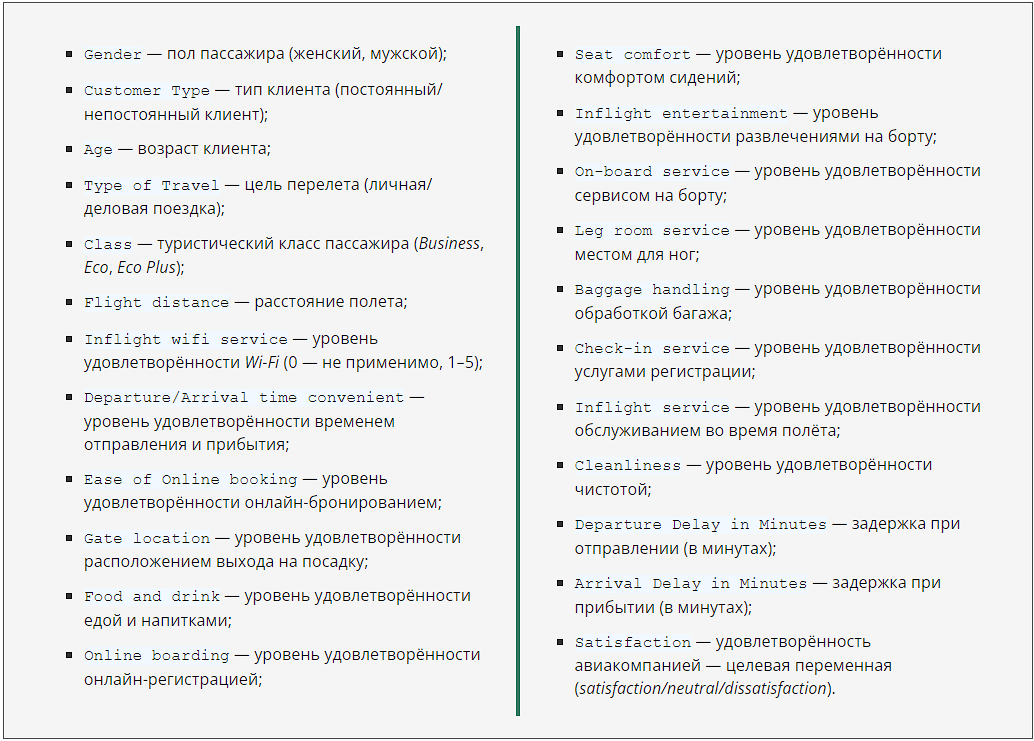

In [3]:
# !pip install xgboost
# !pip install catboost

In [4]:
df = pd.read_csv('data/AirPass.zip', index_col=0)
TARGET = 'satisfaction'
df

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     103904 no

In [6]:
df.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [7]:
df.fillna({'Arrival Delay in Minutes': df['Arrival Delay in Minutes'].median()}, inplace=True)
df['Arrival Delay in Minutes'].mean().round(2)

15.13

In [8]:
df.describe(include='object').T

,count,unique,top,freq
Gender,103904,2,Female,52727
Customer Type,103904,2,Loyal Customer,84923
Type of Travel,103904,2,Business travel,71655
Class,103904,3,Business,49665
satisfaction,103904,2,neutral or dissatisfied,58879


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
Age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
Flight Distance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
Inflight wifi service,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
Departure/Arrival time convenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
Ease of Online booking,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
Gate location,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
Food and drink,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
Online boarding,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0
Seat comfort,103904.0,3.439396,1.319088,0.0,2.00,4.0,5.00,5.0


In [10]:
df.shape

(103904, 24)

# Доля уникальных объектов

In [11]:
(df.nunique() / df.shape[0] * 100).to_frame().round(2).rename(columns={0: 'share, %'})

,"share, %"
id,100.00
Gender,0.00
Customer Type,0.00
Age,0.07
Type of Travel,0.00
Class,0.00
Flight Distance,3.66
Inflight wifi service,0.01
Departure/Arrival time convenient,0.01
Ease of Online booking,0.01


id это просто номер во внутренней базе, абсолютно уникальный признак. Удаляю, он бесполезен.

# Проверка наличия дубликатов

In [12]:
df.duplicated().sum()

0

### Проверка сбалансированности классов целевого признака

In [13]:
(df[TARGET].value_counts(True) * 100).round(2)

satisfaction
neutral or dissatisfied    56.67
satisfied                  43.33
Name: proportion, dtype: float64

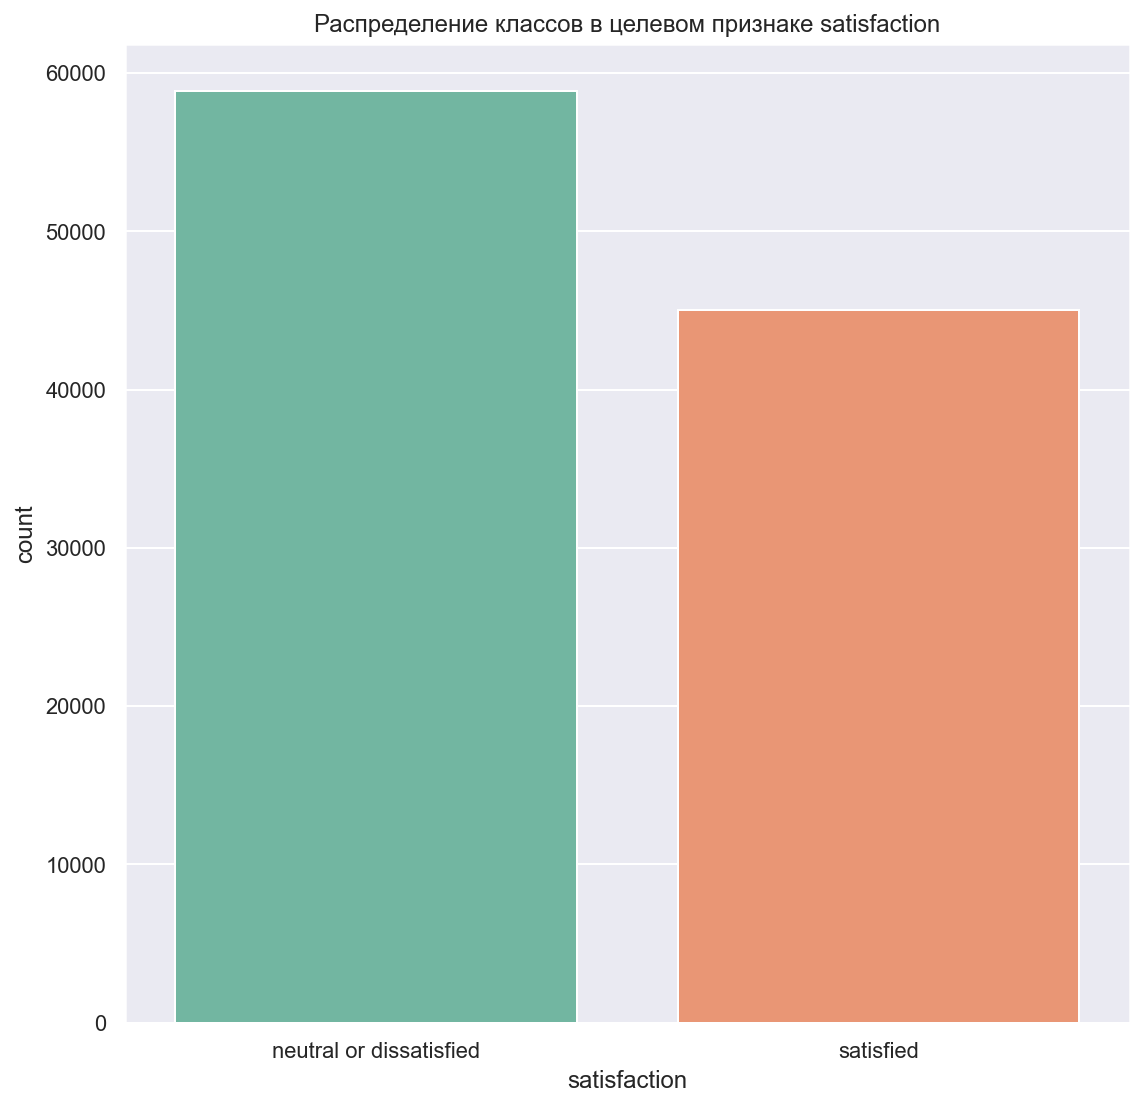

In [14]:
fig = plt.figure(figsize=(9, 9))
sns.countplot(data=df, x=TARGET)
plt.title(f'Распределение классов в целевом признаке {TARGET}')
plt.show()

Классы немного не сбалансированны, нужно использовать стратифицированное разбиение, взвешенвание классов, и метрики отличные от accuracy

In [15]:
num_columns = df.select_dtypes(include=np.number).columns.to_list()
num_columns

['id',
 'Age',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

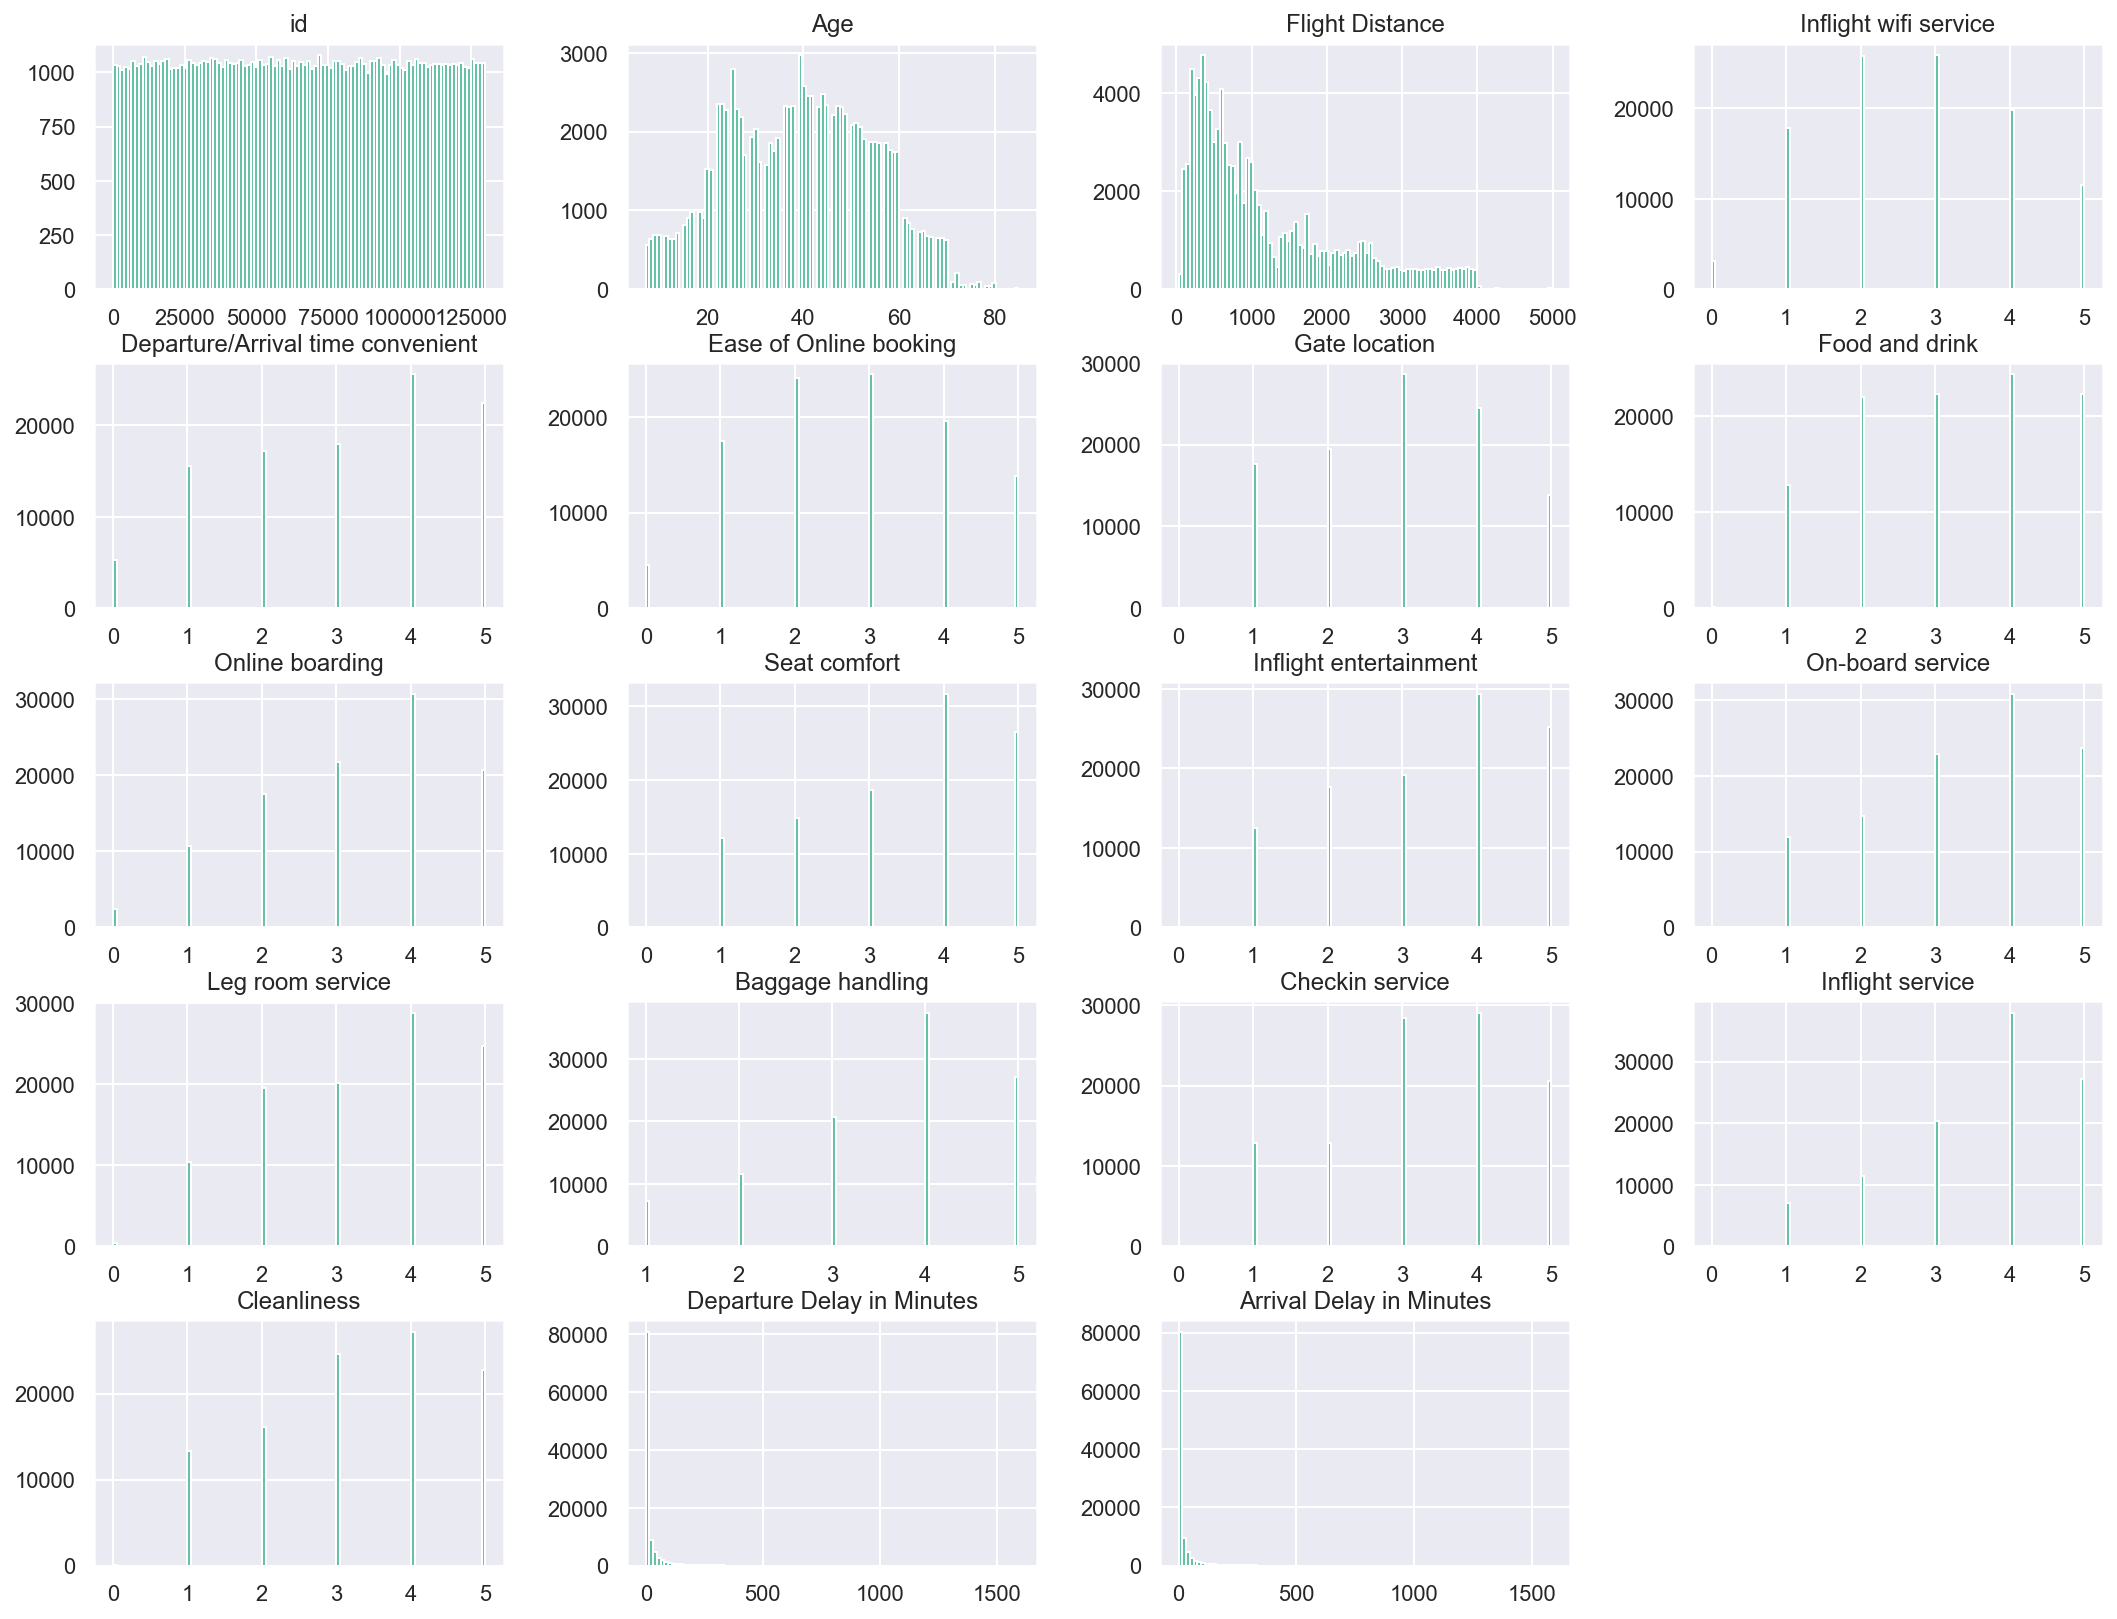

In [16]:
# Распределение по всем числовым признакам
df[num_columns].hist(figsize=(18, 14), bins=100);

Действительно числовые признаки это Age, Flight Distance.
Остальные числовые признаки являются категориальными порядковыми.

# EDA

### Gender

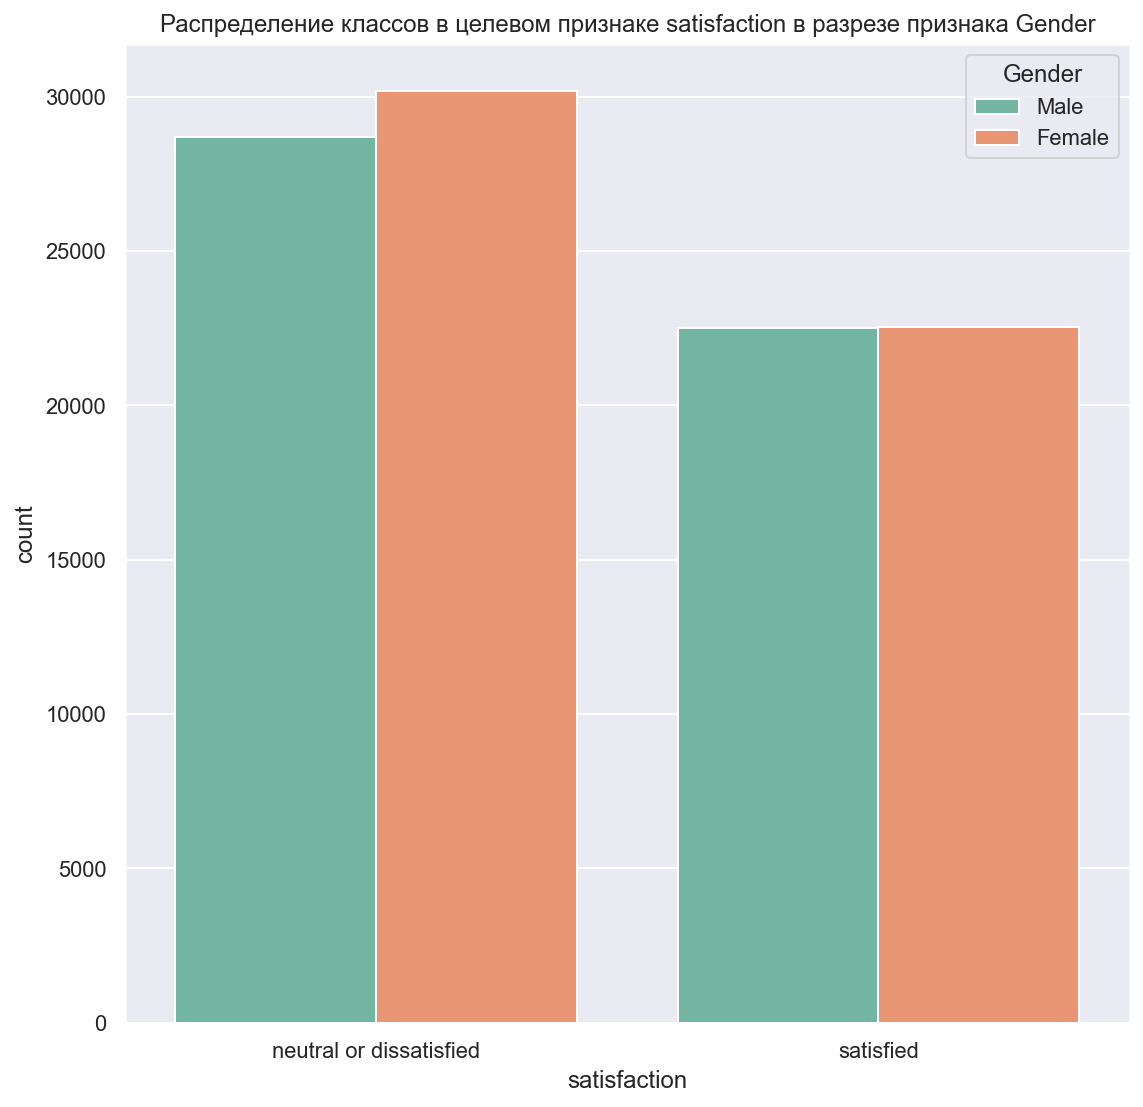

In [17]:
x_class = 'Gender'
fig = plt.figure(figsize=(9, 9))
sns.countplot(data=df, x=TARGET, hue=x_class)
plt.title(f'Распределение классов в целевом признаке {TARGET} в разрезе признака {x_class}')
plt.show()

In [18]:
df.pivot_table(index='satisfaction', columns=x_class, aggfunc='size')

Gender,Female,Male
satisfaction,,
neutral or dissatisfied,30193,28686
satisfied,22534,22491


### Type of Travel

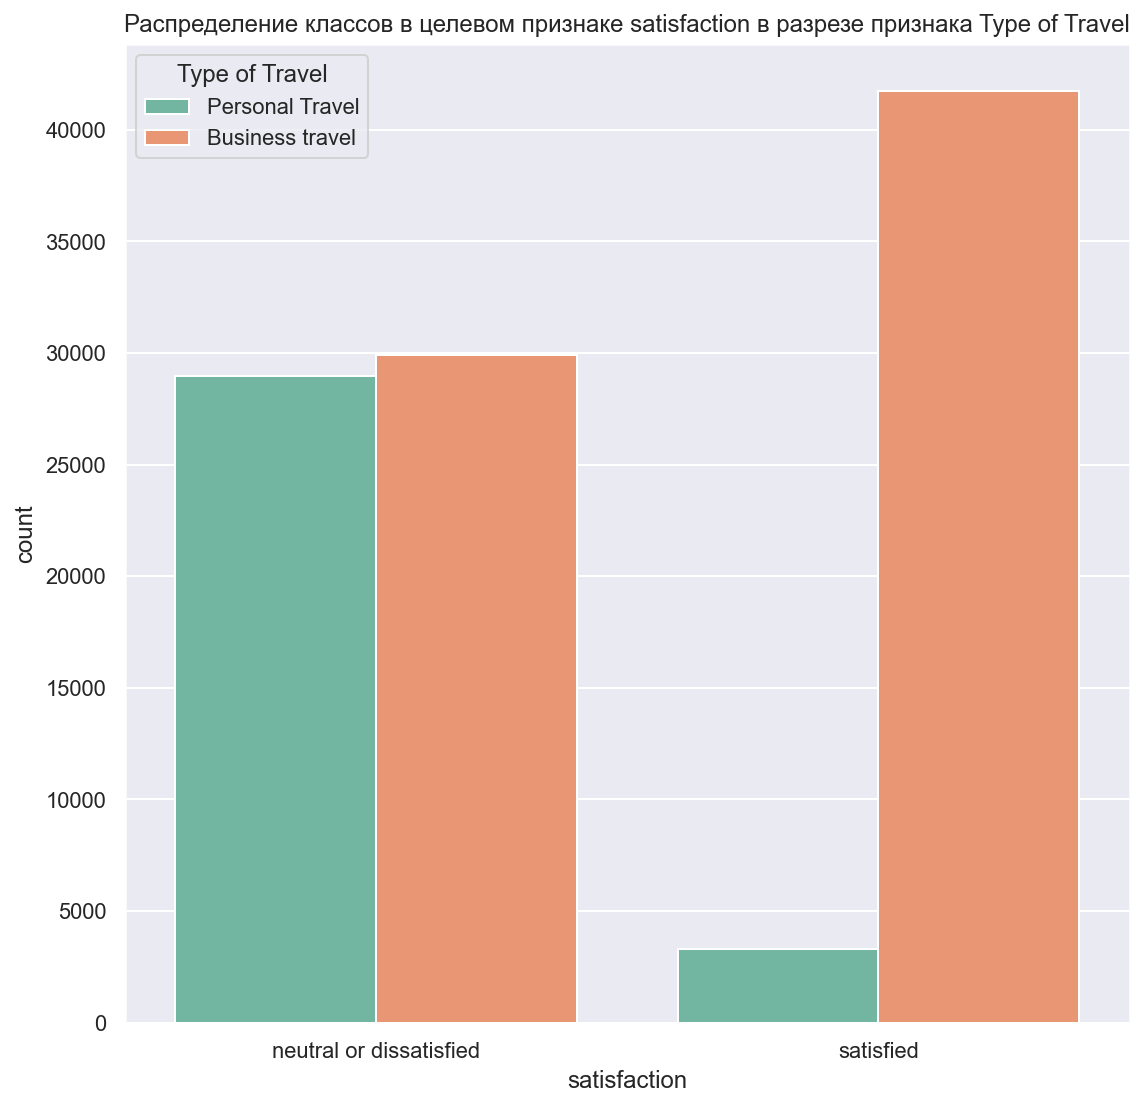

In [19]:
x_class = 'Type of Travel'
fig = plt.figure(figsize=(9, 9))
sns.countplot(data=df, x=TARGET, hue=x_class)
plt.title(f'Распределение классов в целевом признаке {TARGET} в разрезе признака {x_class}')
plt.show()

In [20]:
df.pivot_table(index='satisfaction', columns=x_class, aggfunc='size')

Type of Travel,Business travel,Personal Travel
satisfaction,,
neutral or dissatisfied,29909,28970
satisfied,41746,3279


### Class

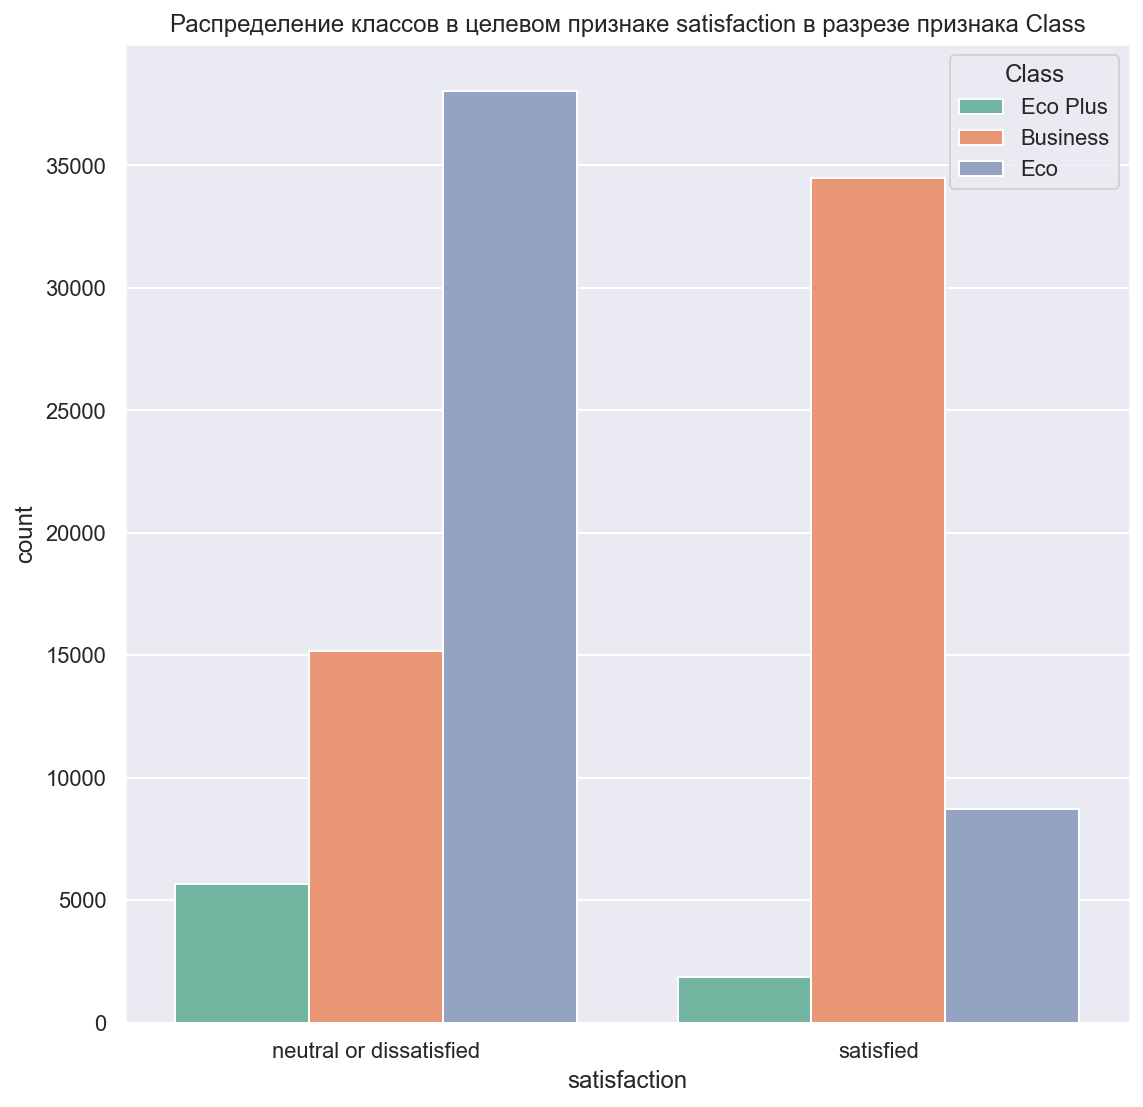

In [21]:
x_class = 'Class'
fig = plt.figure(figsize=(9, 9))
sns.countplot(data=df, x=TARGET, hue=x_class)
plt.title(f'Распределение классов в целевом признаке {TARGET} в разрезе признака {x_class}')
plt.show()

In [22]:
df.pivot_table(index='satisfaction', columns=x_class, aggfunc='size')

Class,Business,Eco,Eco Plus
satisfaction,,,
neutral or dissatisfied,15185,38044,5650
satisfied,34480,8701,1844


### Перекодируем часть бинарных признаков, чтобы использовать их при обучении

In [23]:
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [24]:
df = pd.get_dummies(df)
df.shape[1]

26

### Создаю матрицу признаков и вектор целевого признака
Делю выборку на тренировочную и тестовую

In [25]:
X, y =  df.drop(columns=TARGET), df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

In [26]:
X_test.shape[0]

20781

### Стандартизация данных

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
X_test.iloc[0, 0].round(2)

0.94

## Baseline
Перейдём к обучению моделей. 

В качестве первой модели возьмём самую простую — логистическую регрессию. 

Мы делаем это для того, чтобы потом сравнивать с ней полученные результаты: 

так вы сможете выяснить, насколько ансамбли смогут улучшить точность прогноза.

Обучите логистическую регрессию с параметрами по умолчанию на наших данных. 

В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [29]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'On train f1_score {f1_score(y_train, y_train_pred):.3f}')
print(f'On test f1_score {f1_score(y_test, y_test_pred):.3f}')

On train f1_score 0.854
On test f1_score 0.855


### Задание 6.8
Теперь перейдём к бустингу. 

Начнём с обучения первой модели — AdaBoost. 

В качестве базовой модели для неё возьмите решающее дерево с параметром random_state = 26.

Обучите AdaBoost, зафиксировав random_state со значением 26 и задав темп обучения 0.01. 

В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [30]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=26),
                           learning_rate=0.01,
                           random_state=26)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'On train f1_score {f1_score(y_train, y_train_pred):.3f}')
print(f'On test f1_score {f1_score(y_test, y_test_pred):.3f}')

On train f1_score 1.000
On test f1_score 0.940


### Задание 6.9
Перейдем к следующему алгоритму — градиентному бустингу.

Будем настраивать количество деревьев и темп обучения, делая перебор по сетке.

Используйте для поиска оптимальных параметров GridSearchCV, а для ускорения работы алгоритма задайте параметр кросс-валидации, равный 3.

Какое наибольшее значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

Примечание. Необходимо указать лучший результат в методе GridSearchCV на тренировочных данных.

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer

params = {'n_estimators': 2 ** np.arange(8), 'learning_rate': 0.1 ** np.arange(3)}
model = GradientBoostingClassifier(random_state=26)
scorer = make_scorer(f1_score, average='binary')

grid_search = GridSearchCV(
    estimator=model,
    param_grid=params, 
    cv=3, 
    n_jobs=-1, # использовать все ядра CPU
    return_train_score=True,
    scoring=scorer
)

grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'On train f1_score {f1_score(y_train, y_train_pred):.3f}')
print(f'On test f1_score {f1_score(y_test, y_test_pred):.3f}')
print(f'Best f1_score: {grid_search.best_score_:.3f}')
print()
print(f'Наилучшие значения гиперпараметров:\n{grid_search.best_params_}')

On train f1_score 0.961
On test f1_score 0.951
Best f1_score: 0.949

Наилучшие значения гиперпараметров:
{'learning_rate': 1.0, 'n_estimators': 128}


### Задание 6.10

Обучите алгоритм XGBoost. Так как он достаточно мощный «из коробки», определите его с параметрами по умолчанию, только задайте random_state = 26. 

Какое значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

Подсказка. Для того чтобы обучить алгоритм XGBoost для решения задачи классификации, вам понадобится XGBClassifier из библиотеки xgboost, установленной ранее. Вся дальнейшая последовательность действий (обучение модели, предсказание, оценка качества) идентична другим алгоритмам, например логистической регрессии.

In [37]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=26)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'On train f1_score {f1_score(y_train, y_train_pred):.3f}')
print(f'On test f1_score {f1_score(y_test, y_test_pred):.3f}')

On train f1_score 0.975
On test f1_score 0.958


### Задание 6.11

Обучите алгоритм CatBoost. Как и XGBoost, будем обучать его с настройками по умолчанию и заданным random_state = 26. 

Какое значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

In [38]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=0, random_state=26)
model.fit(X_train.values, y_train.values)

y_train_pred = model.predict(X_train.values)
y_test_pred = model.predict(X_test.values)

print(f'On train f1_score {f1_score(y_train, y_train_pred):.3f}')
print(f'On test f1_score {f1_score(y_test, y_test_pred):.3f}')

On train f1_score 0.974
On test f1_score 0.960


In [50]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[46647,   559],
       [ 1273, 34644]], dtype=int64)

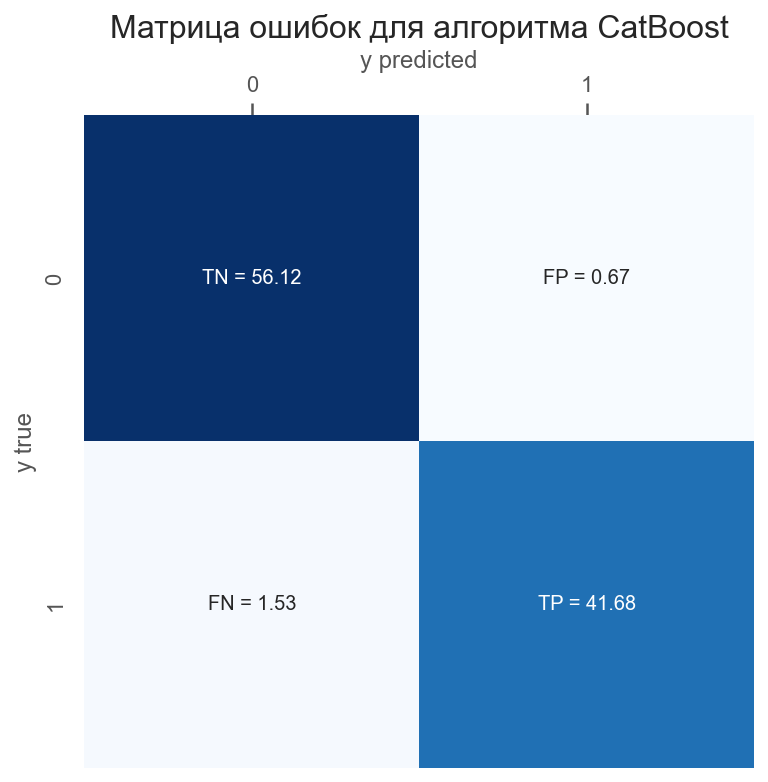

In [52]:
hd.plot_confusion_matrix(cm, 'Матрица ошибок для алгоритма CatBoost', True)

In [54]:
from catboost import Pool
from catboost.utils import get_confusion_matrix

cm = get_confusion_matrix(model, Pool(X_train.values, y_train.values))
cm  = (cm / cm.sum() * 100).round()
print(cm)

[[56.  1.]
 [ 2. 42.]]


In [59]:
pd.DataFrame({'importance': model.feature_importances_}, 
             index=X_train.columns).sort_values(by='importance', ascending=False)

,importance
Inflight wifi service,26.001691
Type of Travel,17.854438
Online boarding,7.582693
Customer Type,7.291082
Class_Business,5.334009
Checkin service,3.935882
Baggage handling,3.675108
Age,3.653960
Gate location,3.537978
Inflight service,2.840194
